In [1]:
import numpy as np
import pandas as pd
import re
import datetime
import math
from matplotlib import pyplot as plt
from functools import partial

In [2]:
df = pd.read_csv('project10_data.csv')
df

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,1/7/23,1/8/23,1/9/23,1/10/23,1/11/23,1/12/23,1/13/23,1/14/23,1/15/23,1/16/23
0,84006075,US,USA,840,6075,San Francisco,California,US,37.752151,-122.438567,...,203871,203871,203871,204696,204696,204696,204806,204806,204806,204806
1,84006075,US,USA,840,6075,San Francisco,California,US,37.752151,-122.438567,...,1114,1114,1114,1114,1116,1123,1129,1137,1137,1137


Exercise 1: Fit a SI Model

(1) 
v(t0) >= 5

In [3]:
# Initialize the max
tmax = 119

# First to clean the table with only the time series data
col_list = []
for col in df.columns:
    if re.search("^[0-9]+", col):
        col_list.append(col)

# df_clean symbolizing all dates with given data
df_clean = df[col_list]
df_clean.columns = pd.to_datetime(df_clean.columns, format="%m/%d/%y")
df_clean
# df_clean

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2023-01-07,2023-01-08,2023-01-09,2023-01-10,2023-01-11,2023-01-12,2023-01-13,2023-01-14,2023-01-15,2023-01-16
0,0,0,0,0,0,0,0,0,0,0,...,203871,203871,203871,204696,204696,204696,204806,204806,204806,204806
1,0,0,0,0,0,0,0,0,0,0,...,1114,1114,1114,1114,1116,1123,1129,1137,1137,1137


In [4]:
# find t0 as the starting time for the simulation
for i in range(len(df_clean.columns)):
    if df_clean.iloc[0, i] >= 5:
        t0 = i
        break
    
print(t0)
print(df_clean.columns[i].date())

45
2020-03-07


Therefore, we find that the t0 happens at t=45, which is 03/07/2020.

(2) 
I(t) = v(t+t0), for 0 <= t <= tmax.
Denote: N_max = population, N_min = 1 + I(tmax)

(2)(a) Implement Algorithm "SI Alg 1 - known N"

In [5]:
# Get population
population = df["Population"][0]

infection_list = list(df_clean.iloc[0])
I_list = infection_list[t0:(t0+tmax+1)]

N_max_a = population
N_min_a = 1 + I_list[-1]

print(f"N_max = {N_max_a}, N_min = {N_min_a}") 

N_max = 881549, N_min = 3863


(2)(a)(i) J(beta, N), jacobian (How to Calibrate SI Models)
<br><br>
(2)(a)(ii) Plot the I(t) for both N_max and N_min, and the predicted value of the infection count based on the SI model

In [6]:
def jacobian(I, beta, N):
    J = 0
    for t in range(0, tmax+1):
        J += math.pow(abs((beta * t - math.log(I[t] / (N - I[t])) + math.log(I[0] / (N - I[0])))), 2)
        
    return J

Running for N = 3863
Estimated: beta = beta_hat = 0.08334705622094742
The value of objective function J(beta, N) is 200.6980201521093
--------------------
Running for N = 881549
Estimated: beta = beta_hat = 0.06786369732468558
The value of objective function J(beta, N) is 249.05070249950745
--------------------


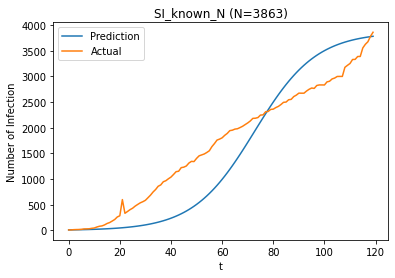

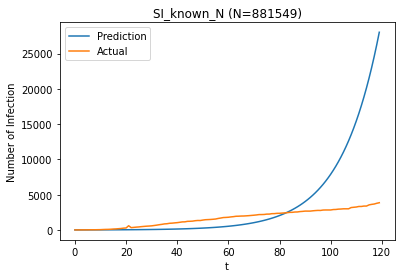

In [7]:
for N_a in [N_min_a, N_max_a]:
    I = I_list

    print(f"Running for N = {N_a}")

    temp = 0
    for t in range(1, tmax+1):
        temp += t * math.log((I[t] / I[0]) * ((N_a - I[0]) / (N_a - I[t])))
    step = 6 / (tmax * (tmax + 1) * (2 * tmax + 1))
    beta_hat_a = step * temp

    print(f"Estimated: beta = beta_hat = {beta_hat_a}")

    J_a = jacobian(I, beta_hat_a, N_a)
    print(f"The value of objective function J(beta, N) is {J_a}")

    tlist = np.arange(0, tmax+1)
    I_func_1 = [N_a * I[0] / (I[0] + (N_a - I[0]) * math.exp(-beta_hat_a * t)) for t in tlist]
    plt.figure()
    plt.plot(I_func_1, label="Prediction")
    plt.plot(I, label="Actual")
    plt.xlabel("t")
    plt.ylabel("Number of Infection")
    plt.title(f"SI_known_N (N={N_a})")
    plt.legend()
    # plt.savefig(f"SI_known_N (N={N}).png")
    print("-" * 20)

(2)(b) Implement Algorithm "SI Alg 2 - Unknown N"

(2)(b)(i) Save intermediate values of J(N) at step 2.1, and plot J = J(N)

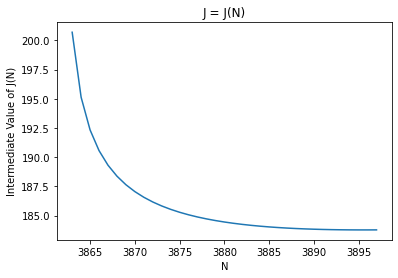

In [14]:
# Initialize data
N_b = N_min_a
J_old = math.inf
a = step

total_J = []
track_N = []
J_b = 0
I = I_list

while True:
    temp1 = 0
    for t in range(1, tmax+1):
        temp1 += math.pow(abs(math.log((I[t] / I[0]) * ((N_b - I[0]) / (N_b - I[t])))), 2)
    
    temp2 = 0
    for t in range(1, tmax+1):
        temp2 += t * math.log((I[t] / I[0]) * ((N_b - I[0]) / (N_b - I[t])))

    J_b = temp1 - a * math.pow(temp2, 2)
    total_J.append(J_b)
    track_N.append(N_b)

    if J_b < J_old:
        J_old = J_b
        N_b += 1
    else:
        break

plt.plot(track_N, total_J)
plt.xlabel("N")
plt.ylabel("Intermediate Value of J(N)")
plt.title("J = J(N)")
plt.show()

(2)(b)(ii) Print the estimates N = N_hat, beta = beta_hat, and the value of objective function J(beta, N)

In [10]:
# N_hat is the last N
N_hat = track_N[-1]

temp3 = 0
for t in range(1, tmax+1):
    temp3 += t * math.log((I[t] / I[0]) * ((N_hat - I[0]) / (N_hat - I[t])))
beta_hat_b = a * temp3

print(f"The estimates N = N_hat = {N_hat}")
print(f"beta = beta_hat = {beta_hat_b}") 
# J = J(N) is the last J value 
print(f"the value of objective function J(beta, N) = {J_b}")

The estimates N = N_hat = 3897
beta = beta_hat = 0.08225041206859607
the value of objective function J(beta, N) = 183.78238465282857


(2)(b)(iii) Plot I(t) and the predicted value of the infection count based on the SI model

--------------------


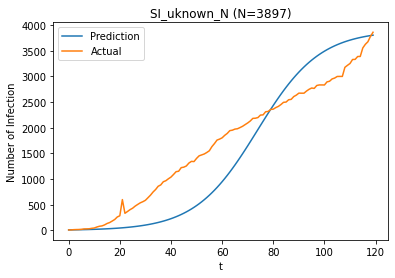

In [15]:
I_func_2 = [N_hat * I[0] / (I[0] + (N_hat - I[0]) * math.exp(-beta_hat_b * t)) for t in tlist]
plt.figure()
plt.plot(I_func_2, label="Prediction")
plt.plot(I, label="Actual")
plt.xlabel("t")
plt.ylabel("Number of Infection")
plt.title(f"SI_uknown_N (N={N_hat})")
plt.legend()
# plt.savefig(f"SI_known_N (N={N}).png")
print("-" * 20)

(2)(b)(iv) Run all values of N from N_min to N_max, and to plot J = J(N) for comparison with (2)(b)(iv)

In [16]:
N_min_b = N_min_a
N_max_b = population

for N_b_2 in range(N_min_a, N_max_a, 100):
    

3863
3963
4063
4163
4263
4363
4463
4563
4663
4763
4863
4963
5063
5163
5263
5363
5463
5563
5663
5763
5863
5963
6063
6163
6263
6363
6463
6563
6663
6763
6863
6963
7063
7163
7263
7363
7463
7563
7663
7763
7863
7963
8063
8163
8263
8363
8463
8563
8663
8763
8863
8963
9063
9163
9263
9363
9463
9563
9663
9763
9863
9963
10063
10163
10263
10363
10463
10563
10663
10763
10863
10963
11063
11163
11263
11363
11463
11563
11663
11763
11863
11963
12063
12163
12263
12363
12463
12563
12663
12763
12863
12963
13063
13163
13263
13363
13463
13563
13663
13763
13863
13963
14063
14163
14263
14363
14463
14563
14663
14763
14863
14963
15063
15163
15263
15363
15463
15563
15663
15763
15863
15963
16063
16163
16263
16363
16463
16563
16663
16763
16863
16963
17063
17163
17263
17363
17463
17563
17663
17763
17863
17963
18063
18163
18263
18363
18463
18563
18663
18763
18863
18963
19063
19163
19263
19363
19463
19563
19663
19763
19863
19963
20063
20163
20263
20363
20463
20563
20663
20763
20863
20963
21063
21163
21263
21363
21463
